In [1]:
import numpy as np
from numpy import pi
from scipy import linalg as la
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Some rotation utility functions

def calculate_rotation_matrix(n,sin,cos):
    '''
    Rotatation matrix around a normal vector n
    By angle theta, passed in as <sin> = sin(theta) and
    <cos> = cos(theta)
    '''
    assert np.abs(la.norm(n) - 1) < 1e-3, 'n must be a unit vector'
    
    n1 = n[0]
    n2 = n[1]
    n3 = n[2]
#     cos = np.sqrt(1-sin**2)
    R = np.zeros((3,3))
    R[0,0] = cos + n1**2 * (1-cos)
    R[0,1] = n1*n2*(1-cos) - n3*sin
    R[0,2] = n1*n3*(1-cos) + n2*sin
    R[1,0] = n1*n2*(1-cos) + n3*sin
    R[1,1] = cos + n2**2 * (1-cos)
    R[1,2] = n2*n3*(1-cos) - n1*sin
    R[2,0] = n1*n3*(1-cos) - n2*sin
    R[2,1] = n2*n3*(1-cos) + n1*sin
    R[2,2] = cos + n3**2 * (1-cos)
    
    return R

def rotate_to_z(v):
    '''
    Takes a vector v and rotates it to be aligned with the z axis
    '''
    normv = la.norm(v)
    v = v / normv
    z = np.array([0,0,1])
    # normal vector between v and z
    n = np.cross(v,z)
    # sin of angle by which to rotate
    sin = la.norm(n)
    cos = np.dot(v,z)
    n = n / sin
    R = calculate_rotation_matrix(n,sin,cos)
    vz = R @ v * normv
    return vz,n,sin

def rotate_z_to_v(z_noisy,v):
    '''
    Takes vector z_noisy and rotates it according to the same rotation
    that would align z with v
    '''
    z = np.array([0,0,1])
    n = np.cross(z,v)
    sin = la.norm(n)
    n = n / sin
    cos = np.dot(z,v)
    R = calculate_rotation_matrix(n,sin,cos)
    v_noisy = R @ z_noisy
    return v_noisy
    

In [7]:
def plot_pointing_vectors(ax, S, V):
    _,N = V.shape
    for i in range(N):
        # get endpoints
        ep1 = S[:,i]
        l = la.norm(ep1)*1.5
        ep2 = ep1 + l * V[:,i]
        ax.plot((ep1[0],ep2[0]),(ep1[1],ep2[1]),(ep1[2],ep2[2]))

In [4]:
def distribute_sensors(n_sensors,lb=5,ub=15):
    '''
    distribute the sensors in a hollowed sphere
    '''
    r = np.random.uniform(lb,ub,n_sensors)
    theta = np.random.uniform(0,np.pi,n_sensors)
    phi = np.random.uniform(0,2*np.pi,n_sensors)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    S = np.vstack((x,y,z))
    return S
    
def form_G(S,a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    _,n = S.shape
    I = np.tile(np.eye(3),(n,1))
    S_norm = la.norm(S,axis=0)
    V1 = -S / S_norm
    V1 = add_noise(a,b,sig_a,sig_b,V1)
    V2 = np.tile(V1,(n,1))
    id_temp = np.kron(np.eye(n),np.ones((3,1)))
    V = V2 * id_temp
    G = np.c_[I,V]
    return G,V1

def add_noise(a, b, sig_a, sig_b, V):
    '''
    Add noise to V along axes a, b
    Characterized by standard deviations sig_a, sig_b
    Assuming that noise is white
    For the nth sensor, assume that z points in the direction of v_n
    x is positive in the left direction
    y is positive in the up direction
    a and b should be orthogonal
    '''
    assert np.dot(a,b) < 1e-3, "a and b must be orthogonal"
    _,N = V.shape
    V_noisy = np.zeros_like(V)
    z = np.array([0,0,1])
    for i in range(N):
        # randomly perturb z along a, b
        theta_a = np.random.normal(0,sig_a,1)
        R_a = calculate_rotation_matrix(a,np.sin(theta_a),np.cos(theta_a))
        theta_b = np.random.normal(0,sig_b,1)
        R_b = calculate_rotation_matrix(b,np.sin(theta_b),np.cos(theta_b))
        z_noisy = R_a @ R_b @ z
        
        v = V[:,i]
        assert np.abs(la.norm(v) - 1) <= 1e-3, "V must be composed of unit column vectors"
        V_noisy[:,i] = rotate_z_to_v(z_noisy, v)
    
    return V_noisy

# Simulation 1
3 Sensors

In [ ]:
tgt = np.zeros(3)
n_sensors = 3
S = distribute_sensors(n_sensors,5,15)

### Noiseless simulation
Triangulate to the origin

In [160]:
G,_ = form_G(S)
r0 = np.reshape(S.T,(3*n_sensors,1))
rt,_,_,_ = la.lstsq(G,r0)
r = rt[:3]
t = rt[3:]
mse = la.norm(r - tgt)**2
print(r)
print(mse)

[[9.71296465e-15]
 [0.00000000e+00]
 [5.11063614e-15]]
3.6138085224278185e-28


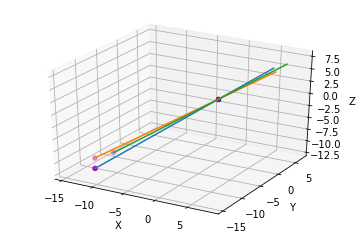

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(S[0,:],S[1,:],S[2,:],c = 'm')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

###############################
# TODO: Show pointing vectors #
###############################
V = -S / la.norm(S,axis=0)
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='b')
ax.scatter(r[0],r[1],r[2],c='r',marker='*')

plt.show()

### Noisy Simulation
Perturb each pointing vector by a Gaussian characterized by $\sigma_a = 0.2$ in the principal direction and $\sigma_b = 0.1$ in the secondary direction.
Let directions $a$ and $b$ just be in the $x$ and $y$ directions, assuming the pointing vector defines the $z$-axis.

In [190]:
G,V = form_G(S,sig_a = 0.2,sig_b = 0.1)
r0 = np.reshape(S.T,(3*n_sensors,1))
rt,_,_,_ = la.lstsq(G,r0)
rt = rt.flatten()
r = rt[:3]
t = rt[3:]
mse = la.norm(r - tgt)**2
print(r)
print(mse)

[-2.88039567 -3.04766924 -2.08339131]
21.925486398869985


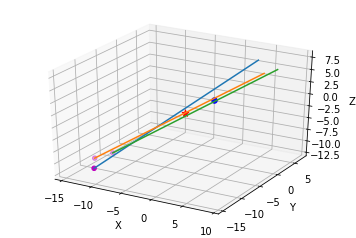

In [195]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(S[0,:],S[1,:],S[2,:],c = 'm')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='b',s=30)
ax.scatter(r[0],r[1],r[2],c='r',marker='*',s=50)

plt.show()

# Simulation 2
15 sensors

In [196]:
tgt = np.zeros(3)
n_sensors = 15
S = distribute_sensors(n_sensors,5,15)

### Noiseless simulation
Triangulate to the origin

In [197]:
G,_ = form_G(S)
r0 = np.reshape(S.T,(3*n_sensors,1))
rt,_,_,_ = la.lstsq(G,r0)
r = rt[:3]
t = rt[3:]
mse = la.norm(r - tgt)**2
print(r)
print(mse)

[[ 0.00000000e+00]
 [ 1.06581410e-14]
 [-2.55014547e-14]]
2.2917604896997098e-27


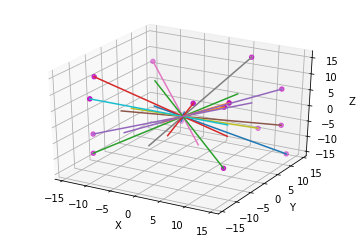

In [198]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(S[0,:],S[1,:],S[2,:],c = 'm')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

###############################
# TODO: Show pointing vectors #
###############################
V = -S / la.norm(S,axis=0)
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='b')
ax.scatter(r[0],r[1],r[2],c='r',marker='*')

plt.show()

### Noisy Simulation
Perturb each pointing vector by a Gaussian characterized by $\sigma_a = 0.2$ in the principal direction and $\sigma_b = 0.1$ in the secondary direction.
Let directions $a$ and $b$ just be in the $x$ and $y$ directions, assuming the pointing vector defines the $z$-axis.

In [199]:
G,V = form_G(S,sig_a = 0.2,sig_b = 0.1)
r0 = np.reshape(S.T,(3*n_sensors,1))
rt,_,_,_ = la.lstsq(G,r0)
rt = rt.flatten()
r = rt[:3]
t = rt[3:]
mse = la.norm(r - tgt)**2
print(r)
print(mse)

[ 1.17424847 -1.4837518  -0.99756332]
4.5755114456062875


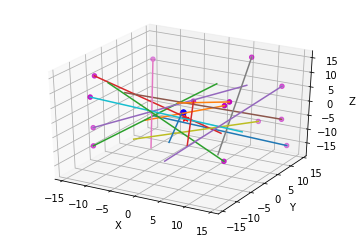

In [200]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(S[0,:],S[1,:],S[2,:],c = 'm')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='b',s=30)
ax.scatter(r[0],r[1],r[2],c='r',marker='*',s=50)

plt.show()

# Remarks:
* A few sensors gives really bad error in the noisy case
* In simulation 1, the sensors were (randomly) oriented in a trio, so their pointing vectors were closely aligned
* A small amount of noise was enough to throw off the estimation
* In simulation 2, the number of sensors was increased 5x, and MSE dropped significantly
* The sensors happened to be arranged in a more uniform ball around the target
* Despite the crazy effects of noise (see the image for the depiction of pointing vectors), the spherical arrangement mitigates the effect of noise
* I inputted a crazy amount of noise - 
    * standard deviation of 0.2rad means there is about a 40% chance of the angle deviating by at least 10 degrees in the principal axis
    * .1rad corresponds to 40% chance of at least 5 degrees deviation in secondary axis

# Simulation 3
To simulate a satellite type thing, we will distribute sensors very far from the origin (such as geostationary orbit distance), distributing them realistically so that occlusion from earth will not happen (i.e. in a half space), and make the noise much smaller

In [18]:
n_sensors = 10
S = distribute_sensors(n_sensors,35786e3-100,35786e3+100)
tgt = np.zeros(3)
S[2,:] = np.abs(S[2,:]) # flip z so that they are all above the "earth"

G,V = form_G(S,sig_a = 39e-6,sig_b = 20e-6)
r0 = np.reshape(S.T,(3*n_sensors,1))
rt,_,_,_ = la.lstsq(G,r0)
rt = rt.flatten()
r = rt[:3]
t = rt[3:]
mse = la.norm((r - tgt)**2)
print(r)
print(mse)

[-778.84661086 1073.83993122 -320.79343691]
1307008.052552843


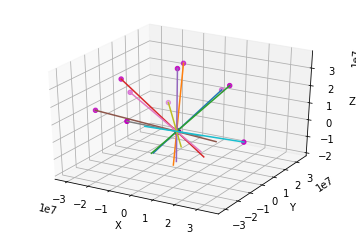

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(S[0,:],S[1,:],S[2,:],c = 'm')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='b',s=30)
ax.scatter(r[0],r[1],r[2],c='r',marker='*',s=50)

plt.show()